In [43]:
import zipfile
import tarfile
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk

In [44]:
import os

# Use forward slashes
os.chdir('c:/Users/binwa/OneDrive/Desktop/Projects/TumorVisNet')

# Confirm the directory change
print(os.getcwd())


c:\Users\binwa\OneDrive\Desktop\Projects\TumorVisNet


In [45]:
import os
os.getcwd()


'c:\\Users\\binwa\\OneDrive\\Desktop\\Projects\\TumorVisNet'

In [46]:
file = tarfile.open('BraTS2021_00495.tar')
file.extractall('MRI/')

In [47]:
file = tarfile.open('BraTS2021_00621.tar')
file.extractall('MRI/')

In [48]:
image = sitk.ReadImage('MRI/BraTS2021_00495_t2.nii.gz')

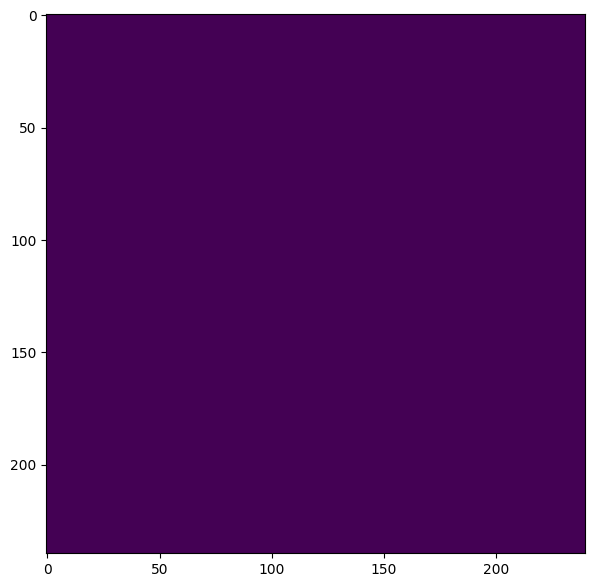

In [49]:
im = sitk.GetArrayFromImage(image)[0]
plt.imshow(np.squeeze(im))

flair    (155, 240, 240)
seg    (155, 240, 240)
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


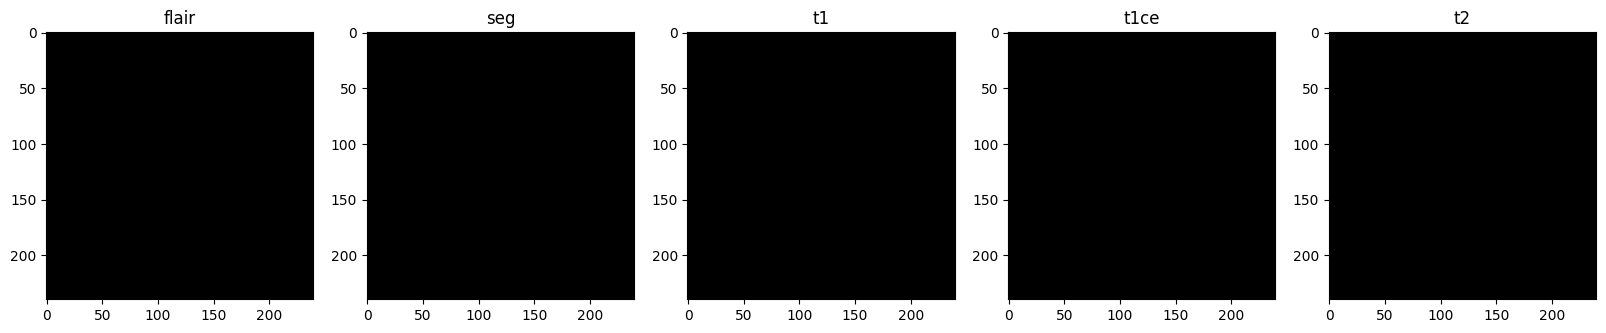

In [50]:
plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('MRI/BraTS2021_00621_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[0])
    
    plt.subplot(1,5,i)
    plt.imshow(im, cmap='gray')
    plt.title(name)


flair    (155, 240, 240)
seg    (155, 240, 240)
t1    (155, 240, 240)
t1ce    (155, 240, 240)
t2    (155, 240, 240)


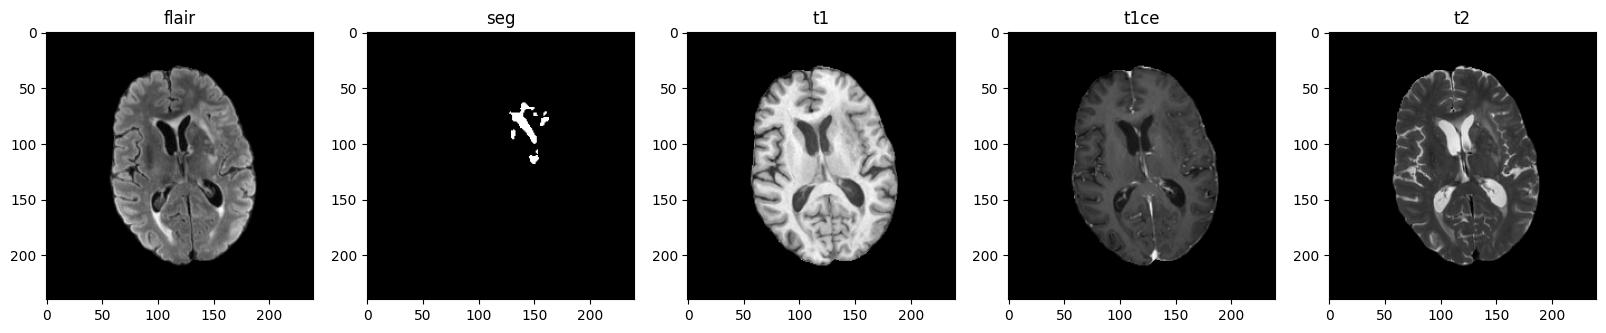

In [51]:
plt.rcParams['figure.figsize'] = (20,20)
for i,name in enumerate(['flair', 'seg', 't1', 't1ce', 't2'],1):
    image = sitk.ReadImage('MRI/BraTS2021_00621_{}.nii.gz'.format(name))
    img_arr = sitk.GetArrayFromImage(image)
    print(name, '  ', img_arr.shape)
    im = np.squeeze(img_arr[80])
    
    plt.subplot(1,5,i)
    plt.imshow(im, cmap='gray')
    plt.title(name)

(240, 240, 155)


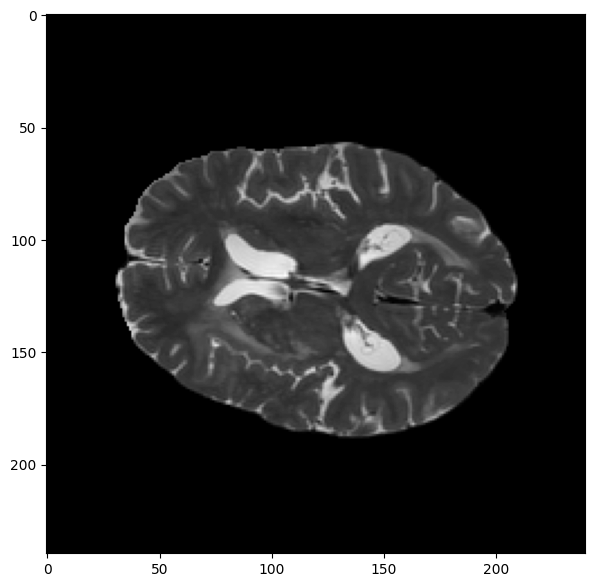

In [52]:
plt.rcParams['figure.figsize'] = (7,7)
nii_img  = nib.load('MRI/BraTS2021_00621_t2.nii.gz').get_fdata()
print(nii_img.shape)
plt.imshow(nii_img[:,:,80], cmap='gray')

(240, 240, 155)


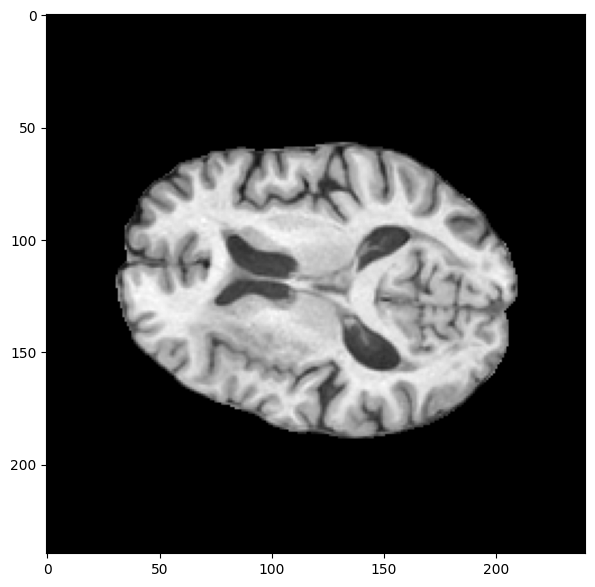

In [53]:
plt.rcParams['figure.figsize'] = (7,7)
nii_img  = nib.load('MRI/BraTS2021_00621_t1.nii.gz').get_fdata()
print(nii_img.shape)
plt.imshow(nii_img[:,:,80], cmap='gray')

In [54]:
from glob import glob

In [55]:
task1_files = glob('MRI/*')

In [56]:
len(task1_files)

10

In [57]:
import albumentations as A
import numpy as np


class ImageReader:
    def __init__(
        self, root:str, img_size:int=256,
        normalize:bool=False, single_class:bool=False
    ) -> None:
        pad_size = 256 if img_size > 256 else 224
        self.resize = A.Compose(
            [
                A.PadIfNeeded(min_height=pad_size, min_width=pad_size, value=0),
                A.Resize(img_size, img_size)
            ]
        )
        self.normalize=normalize
        self.single_class=single_class
        self.root=root
        
    def read_file(self, path:str) -> dict:
        scan_type = path.split('_')[-1]
        raw_image = nib.load(path).get_fdata()
        raw_mask = nib.load(path.replace(scan_type, 'seg.nii.gz')).get_fdata()
        processed_frames, processed_masks = [], []
        for frame_idx in range(raw_image.shape[2]):
            frame = raw_image[:, :, frame_idx]
            mask = raw_mask[:, :, frame_idx]
            resized = self.resize(image=frame, mask=mask)
            processed_frames.append(resized['image'])
            processed_masks.append(
                1*(resized['mask'] > 0) if self.single_class else resized['mask']
            )
        scan_data = np.stack(processed_frames, 0)
        if self.normalize:
            if scan_data.max() > 0:
                scan_data = scan_data/scan_data.max()
            scan_data = scan_data.astype(np.float32)
        return {
            'scan': scan_data,
            'segmentation': np.stack(processed_masks, 0),
            'orig_shape': raw_image.shape
        }
    
    def load_patient_scan(self, idx:int, scan_type:str='flair') -> dict:
        patient_id = str(idx).zfill(5)
        scan_filename = f'MRI/BraTS2021_00621_t1.nii.gz'
        return self.read_file(scan_filename)
            

In [58]:
reader = ImageReader('MRI/', img_size=128, normalize=True, single_class=False)

In [59]:
from skimage.morphology import binary_closing
import plotly.express as px

data = reader.load_patient_scan(0)

image = data['scan'][60]
masked_image = 1 * (image > 0)
filled_image = 1 * binary_closing(image)

px.imshow(
    np.array([image, masked_image, filled_image]),
    facet_col=0, title="Different image masking - none, threshold and binary closing",
)

In [60]:
def pix_count(scan:np.array, close:bool=False, mask:bool=False, mask_idx:int=-1) -> int:
    slice_areas = []
    for slice_idx in range(scan.shape[0]):
        if close:
            mri = 1 * binary_closing(scan[slice_idx, :, :])
        elif mask_idx >= 0:
            mri = 1 * (scan[slice_idx, :, :] == mask_idx)
        elif mask:
            mri = 1 * (scan[slice_idx, :, :] > 0)
        else:
            raise ValueError('Masking mechanism should be specified')
        mri_area = mri.sum()
        slice_areas.append(mri_area)
    return np.sum(slice_areas)

pix_count(data['segmentation'], mask=True) / pix_count(data['scan'], mask=True)

0.017031667740199236

In [61]:
def get_centroid(scan:np.array, mask_idx:int=1) -> list:
    z, x, y = (scan == mask_idx).nonzero()
    x, y, z = np.median(x), np.median(y), np.median(z)
    return [x/scan.shape[1], y/scan.shape[2], z/scan.shape[0]]

get_centroid(data['segmentation'], 4), get_centroid(data['segmentation'], 1)

c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning:

Mean of empty slice.

c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:

invalid value encountered in scalar divide



([0.59375, 0.390625, 0.3225806451612903], [nan, nan, nan])

In [62]:
import cv2
import tensorflow as tf

In [63]:
images_path = 'Data/BraTS2021'

In [64]:
import nibabel as nib
import os
import albumentations as A
import numpy as np

In [65]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

In [66]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing

In [67]:
data_path = [f.path for f in os.scandir(images_path ) if f.is_dir()]

def data_list(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

data_id = data_list(data_path); 

   
train_, val_ = train_test_split(data_id,test_size=0.2) 
train_files, test_files = train_test_split(train_,test_size=0.15) 

In [68]:
IMG_SIZE=128

In [69]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=4, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(Batch_ids):
            # Construct the correct case path by ensuring both the folder and file name are used
            case_folder = os.path.join(images_path, os.path.basename(i))  # e.g., 'Data/BraTS2021/BraTS2021_00565'
            case_path = os.path.join(case_folder, os.path.basename(i))    # e.g., 'Data/BraTS2021/BraTS2021_00565/BraTS2021_00565'

            print(f"Batch {Batch_ids}")
            print(f"Case Path: {case_path}")
            print(f"Processed patient: {c}")

            # Load modalities and segmentation
            flair_path = f'{case_path}_flair.nii'
            flair = nib.load(flair_path).get_fdata()

            ce_path = f'{case_path}_t1ce.nii'
            ce = nib.load(ce_path).get_fdata()

            t1_path = f'{case_path}_t1.nii'
            t1 = nib.load(ce_path).get_fdata()

            t2_path = f'{case_path}_t2.nii'
            t2 = nib.load(ce_path).get_fdata()

            seg_path = f'{case_path}_seg.nii'
            seg = nib.load(seg_path).get_fdata()

            # Process slices for each modality
            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 2] = cv2.resize(t1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 3] = cv2.resize(t2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]


        # Generate masks
        y[y == 4] = 3  # Adjust class values as needed
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y


# Initialize the data generators
training_generator = DataGenerator(train_files)
valid_generator = DataGenerator(val_)
test_generator = DataGenerator(test_files)


C:\Users\binwa\AppData\Local\Temp\ipykernel_66464\3954633554.py:4: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



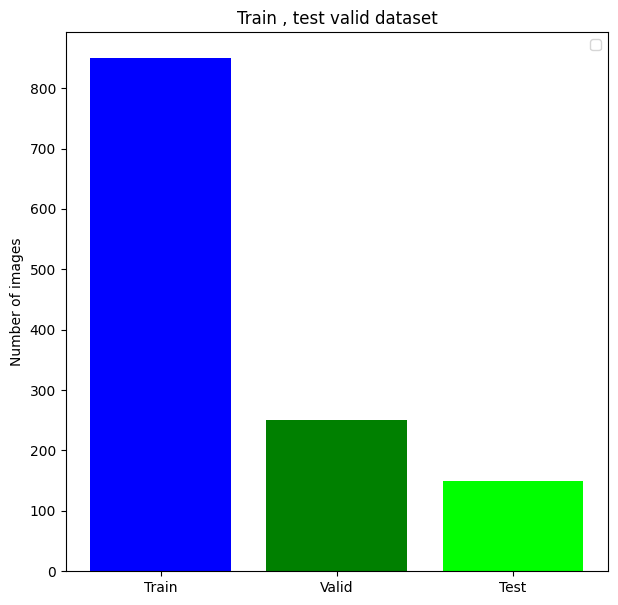

In [93]:
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_files), len(val_), len(test_files)], align='center',color=[ 'blue','green', 'lime'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Train , test valid dataset')

    plt.show()
    
showDataLayout()

In [71]:
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten

In [72]:
from keras.models import Model, load_model
from keras.layers import Input ,BatchNormalization , Activation 
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [73]:
from keras.layers import concatenate

In [74]:
def cnn_vit_bottleneck(cnn_output, patch_size=8, embed_dim=256):
    """
    Tokenizes the CNN output into patches suitable for the ViT.
    Args:
        cnn_output: Output feature map from the CNN (before the ViT bottleneck).
        patch_size: Size of each patch (should match the input size of the ViT).
        embed_dim: Embedding dimension for the transformer (must match transformer).
    Returns:
        tokens: Flattened patches to be passed to the transformer.
    """
    # Reshape CNN output to patches
    patches = tf.image.extract_patches(
        images=cnn_output,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='SAME'
    )

    # Flatten the patches into tokens
    patches = tf.reshape(patches, [tf.shape(cnn_output)[0], -1, patch_size * patch_size * cnn_output.shape[-1]])

    # Project patches into transformer embedding dimension
    tokens = Dense(embed_dim)(patches)
    
    return tokens


In [75]:
def vit_transformer_block(tokens, embed_dim=256, num_heads=8, ff_dim=512, dropout_rate=0.1):
    """
    Vision Transformer block with multi-head self-attention and feed-forward layers.
    Args:
        tokens: Flattened patches (tokens) to be passed through the transformer.
        embed_dim: Embedding dimension for the transformer.
        num_heads: Number of attention heads.
        ff_dim: Feed-forward network dimension.
        dropout_rate: Dropout rate for regularization.
    Returns:
        transformer_output: The output of the transformer block.
    """
    # Layer normalization
    x = LayerNormalization()(tokens)

    # Multi-head self-attention layer
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attention_output = Dropout(dropout_rate)(attention_output)

    # Add & Normalize (residual connection)
    x = Add()([attention_output, x])
    x = LayerNormalization()(x)

    # Feed-forward network (FFN)
    ffn_output = Dense(ff_dim, activation='relu')(x)
    ffn_output = Dense(embed_dim)(ffn_output)  # Ensure embedding dim matches the input
    ffn_output = Dropout(dropout_rate)(ffn_output)

    # Add & Normalize (residual connection)
    transformer_output = Add()([ffn_output, x])

    return transformer_output


In [76]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense, Dropout

def transformer_block(x, num_heads, ff_dim, dropout_rate=0.1):
    # Self-Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(x, x)
    attention_output = Dropout(dropout_rate)(attention_output)
    # Add & Normalize
    x = LayerNormalization(epsilon=1e-6)(x + attention_output)

    # Feed-forward network
    ff_output = Dense(ff_dim, activation='relu')(x)
    ff_output = Dropout(dropout_rate)(ff_output)
    # Add & Normalize
    x = LayerNormalization(epsilon=1e-6)(x + ff_output)
    
    return x

def deep_CNN_u_with_ViT(inputs, ker_init, dropout, num_heads=4, ff_dim=512):
    # Encoder (Same as your existing U-Net)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    # Bottleneck with Transformer Block
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)
    
    # Transformer integration (Add Multi-Head Attention and Layer Normalization)
    transformer_out = transformer_block(drop5, num_heads=num_heads, ff_dim=ff_dim)
    
    # Decoder (Same as your existing U-Net)
    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(transformer_out))
    merge7 = concatenate([conv3, up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2, up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv, up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1, up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

# Input layer and model creation
input_layer = Input((128, 128, 4 ))  # Input is same (128x128, 2 channels)
model_with_ViT = deep_CNN_u_with_ViT(input_layer, 'he_normal', 0.2)

# Compile the model with the same metrics and loss function



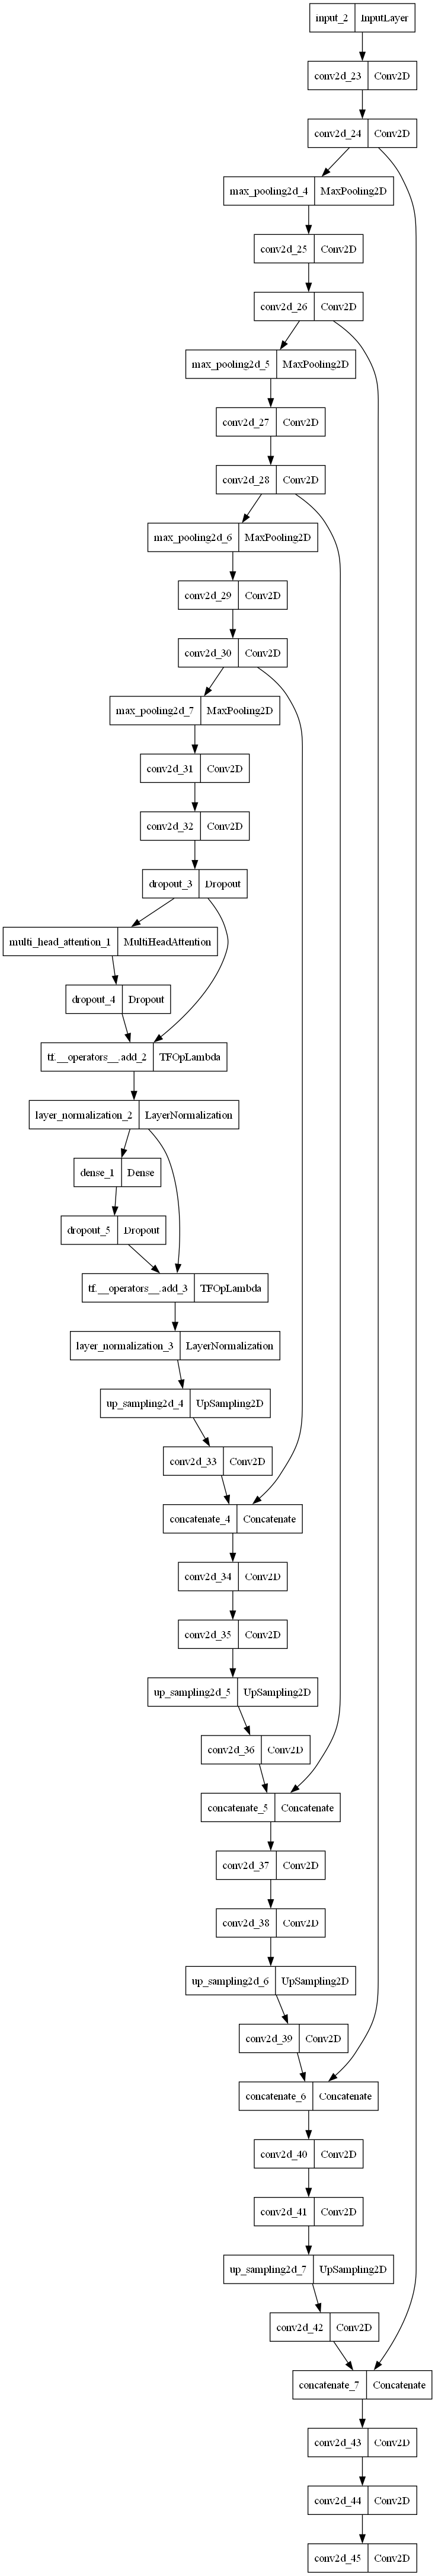

In [77]:
plot_model(model_with_ViT)

In [78]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE',
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 

In [79]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [80]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [81]:
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

In [82]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

In [83]:
model_with_ViT.compile(
    loss="categorical_crossentropy", 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity]
)

In [84]:
history_with_ViT = model_with_ViT.fit(
    training_generator,
    epochs=5,
    validation_data=valid_generator
)


Batch ['BraTS2021\\BraTS2021_01135']
Case Path: Data/BraTS2021\BraTS2021_01135\BraTS2021_01135
Processed patient: 0
Epoch 1/5
Batch ['BraTS2021\\BraTS2021_01070']
Case Path: Data/BraTS2021\BraTS2021_01070\BraTS2021_01070
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_01358']
Case Path: Data/BraTS2021\BraTS2021_01358\BraTS2021_01358
Processed patient: 0
  1/850 [..............................] - ETA: 3:31:08 - loss: 1.5956 - accuracy: 0.0040 - mean_io_u_1: 0.3762 - dice_coef: 0.0962 - precision: 0.0000e+00 - sensitivity: 0.0000e+00 - specificity: 0.9992Batch ['BraTS2021\\BraTS2021_00369']
Case Path: Data/BraTS2021\BraTS2021_00369\BraTS2021_00369
Processed patient: 0
  2/850 [..............................] - ETA: 2:34:02 - loss: 1.1337 - accuracy: 0.4625 - mean_io_u_1: 0.3760 - dice_coef: 0.1395 - precision: 0.4816 - sensitivity: 0.3585 - specificity: 0.9951        Batch ['BraTS2021\\BraTS2021_01381']
Case Path: Data/BraTS2021\BraTS2021_01381\BraTS2021_01381
Processed patient: 0
  3/

In [85]:
# Save the entire model after training
model_with_ViT.save('Models/Trained_4modalityvisnetCNN_Model.h5')  # You can choose any filename, e.g., 'my_model.h5'


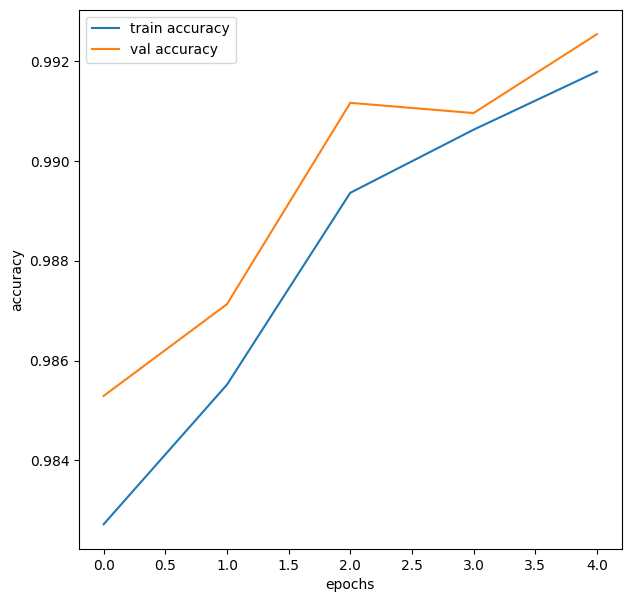

In [92]:
epochs = list(range(5))
acc = history_with_ViT.history['accuracy']
val_acc = history_with_ViT.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

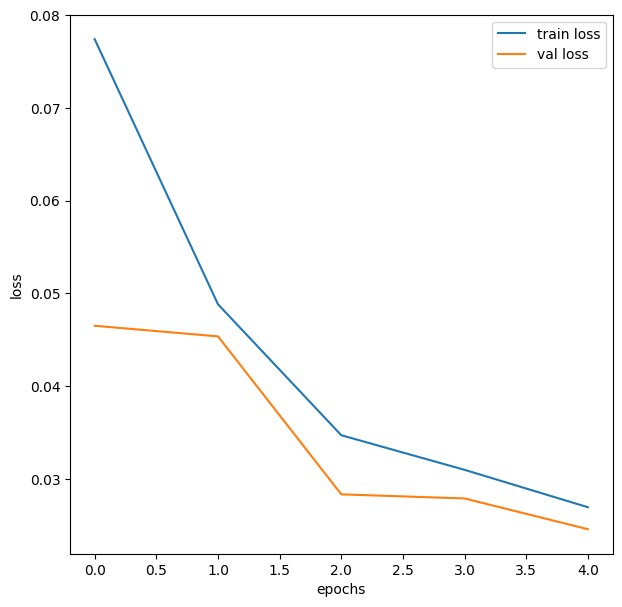

In [87]:
loss = history_with_ViT.history['loss']
val_loss = history_with_ViT.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

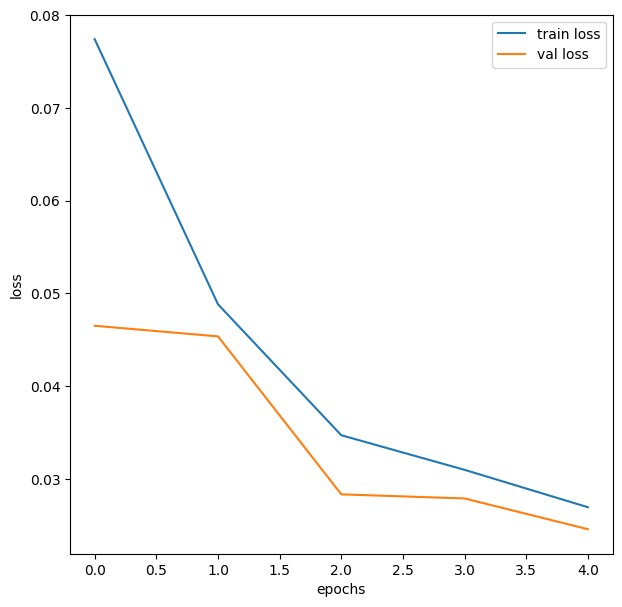

In [88]:
loss = history_with_ViT.history['loss']
val_loss = history_with_ViT.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [97]:

import pandas as pd

# Extract metrics from training history

epochs = list(range(1, len(history_with_ViT['accuracy']) + 1))

# Creating a DataFrame to present these metrics in a table format
metrics_table = pd.DataFrame({
    'Epoch': epochs,
    'Accuracy': history_with_ViT['accuracy'],
    'Val Accuracy': history_with_ViT['val_accuracy'],
    'Mean IoU': history_with_ViT['mean_io_u_1'],
    'Val Mean IoU': history_with_ViT['val_mean_io_u_1'],
    'Dice Coefficient': history_with_ViT['dice_coef'],
    'Val Dice Coefficient': history_with_ViT['val_dice_coef'],
    'Precision': history_with_ViT['precision'],
    'Val Precision': history_with_ViT['val_precision'],
    'Sensitivity': history_with_ViT['sensitivity'],
    'Val Sensitivity': history_with_ViT['val_sensitivity'],
    'Specificity': history_with_ViT['specificity'],
    'Val Specificity': history_with_ViT['val_specificity'],
})

# Print the DataFrame
print(metrics_table)


   Epoch  Accuracy  Val Accuracy  Mean IoU  Val Mean IoU  Dice Coefficient  \
0      1  0.982723      0.985293  0.375531      0.375551          0.288372   
1      2  0.985517      0.987130  0.375532      0.375551          0.369435   
2      3  0.989360      0.991162  0.375532      0.375551          0.463929   
3      4  0.990624      0.990957  0.375532      0.375551          0.511441   
4      5  0.991785      0.992536  0.375531      0.375551          0.550360   

   Val Dice Coefficient  Precision  Val Precision  Sensitivity  \
0              0.359267   0.983914       0.989508     0.980788   
1              0.406506   0.989414       0.989349     0.982167   
2              0.554038   0.991395       0.992197     0.986895   
3              0.523970   0.992024       0.992720     0.988590   
4              0.587995   0.992767       0.993196     0.990017   

   Val Sensitivity  Specificity  Val Specificity  
0         0.981369     0.995035         0.996437  
1         0.984648     0.996420 

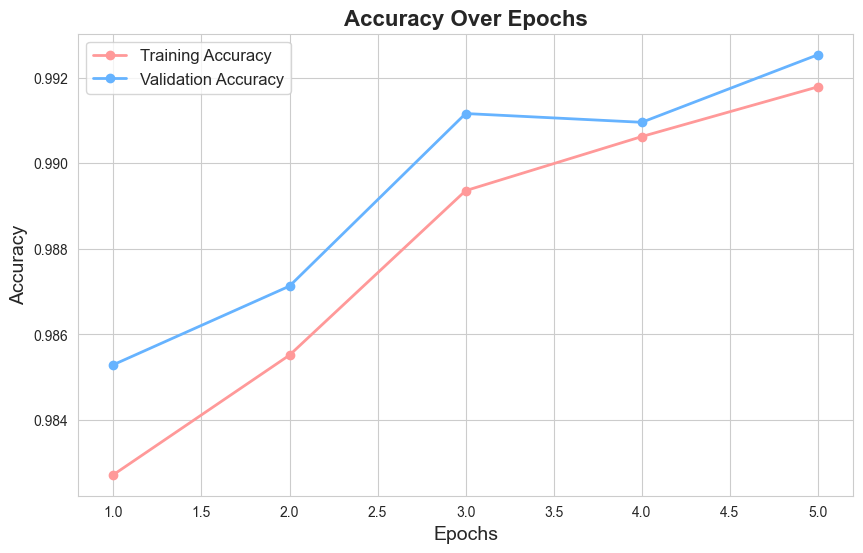

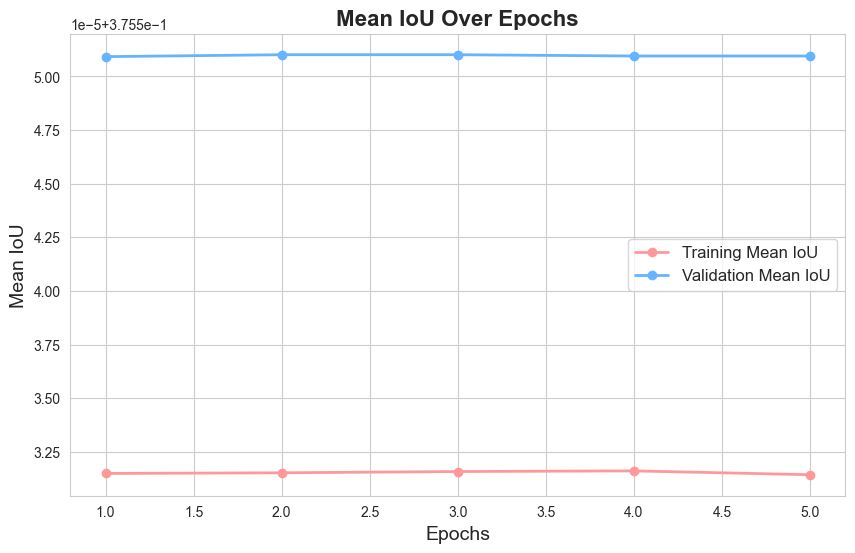

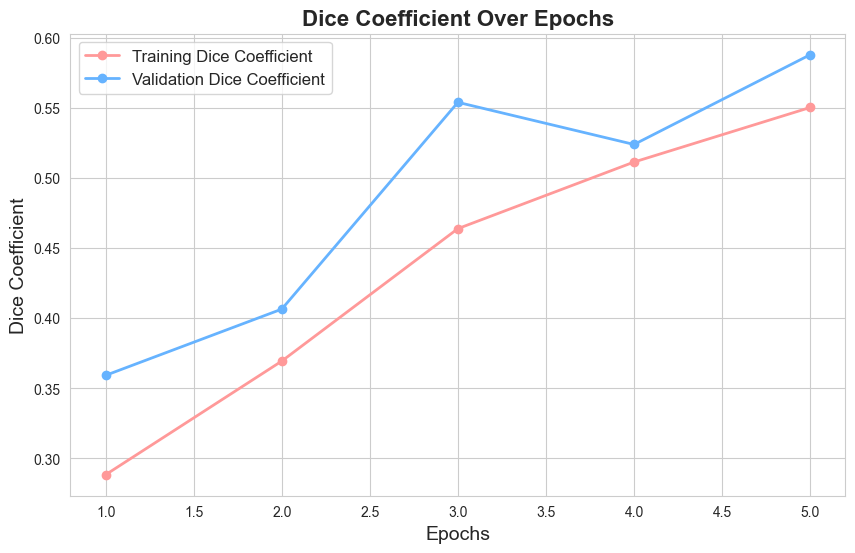

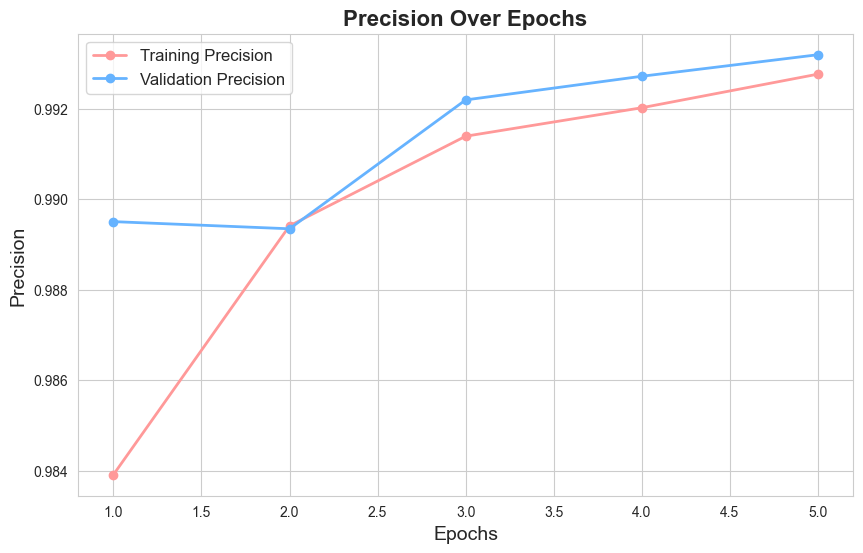

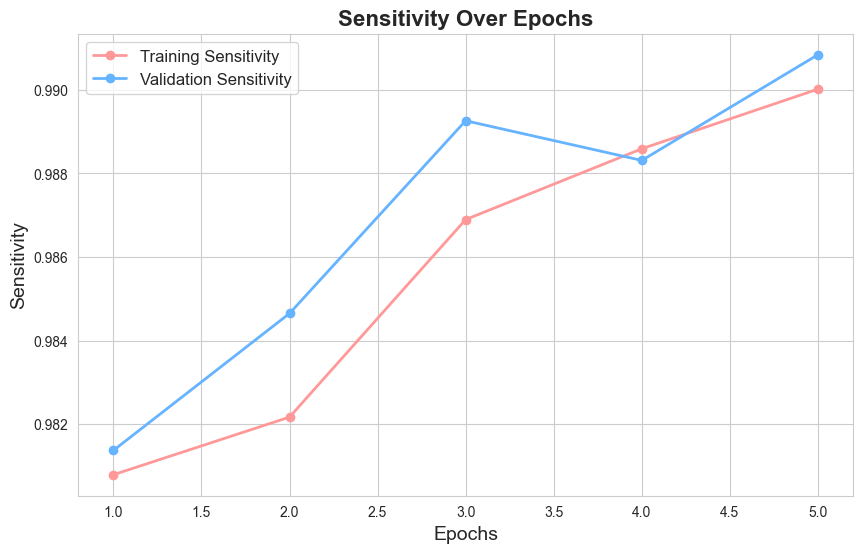

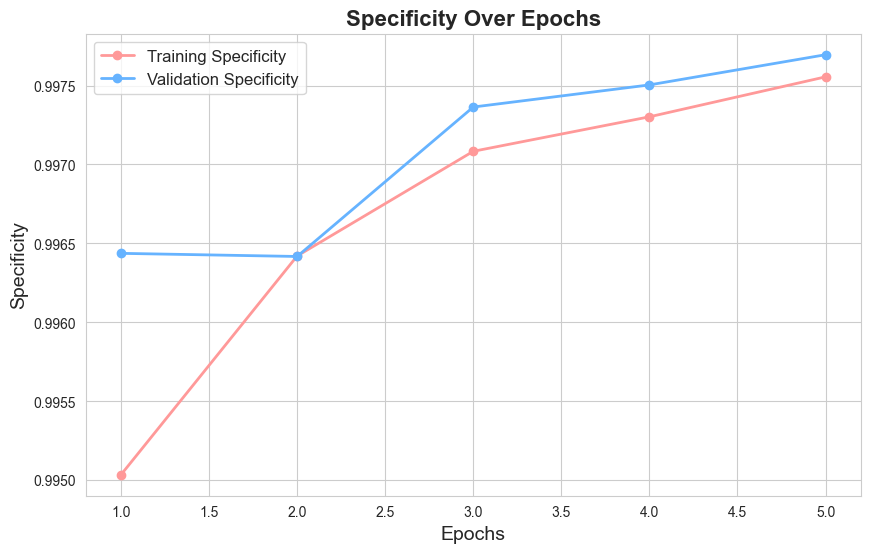

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

# Customize colors and plot appearance
sns.set_style("whitegrid")
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']

def plot_custom_metric(metric_name, train_values, val_values, epochs, save_path):
    plt.figure(figsize=(10, 6))
    
    # Plot training and validation curves
    plt.plot(epochs, train_values, label=f'Training {metric_name}', color=colors[0], linewidth=2, marker='o')
    plt.plot(epochs, val_values, label=f'Validation {metric_name}', color=colors[1], linewidth=2, marker='o')
    
    # Customize plot appearance
    plt.title(f'{metric_name} Over Epochs', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    
    # Save the plot as an image file
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()

# Plot and save all the metrics
plot_custom_metric("Accuracy", history_with_ViT['accuracy'], history_with_ViT['val_accuracy'], epochs, "Visualization/4MVitUnet_accuracy_plot.png")
plot_custom_metric("Mean IoU", history_with_ViT['mean_io_u_1'], history_with_ViT['val_mean_io_u_1'], epochs, "Visualization/4MVitUnet_mean_iou_plot.png")
plot_custom_metric("Dice Coefficient", history_with_ViT['dice_coef'], history_with_ViT['val_dice_coef'], epochs, "Visualization/4MVitUnet_dice_plot.png")
plot_custom_metric("Precision", history_with_ViT['precision'], history_with_ViT['val_precision'], epochs, "Visualization/4MVitUnet_precision_plot.png")
plot_custom_metric("Sensitivity", history_with_ViT['sensitivity'], history_with_ViT['val_sensitivity'], epochs, "Visualization/4MVitUnet_sensitivity_plot.png")
plot_custom_metric("Specificity", history_with_ViT['specificity'], history_with_ViT['val_specificity'], epochs, "Visualization/4MVitUnet_specificity_plot.png")


5/5 [==============================] - 4s 798ms/step


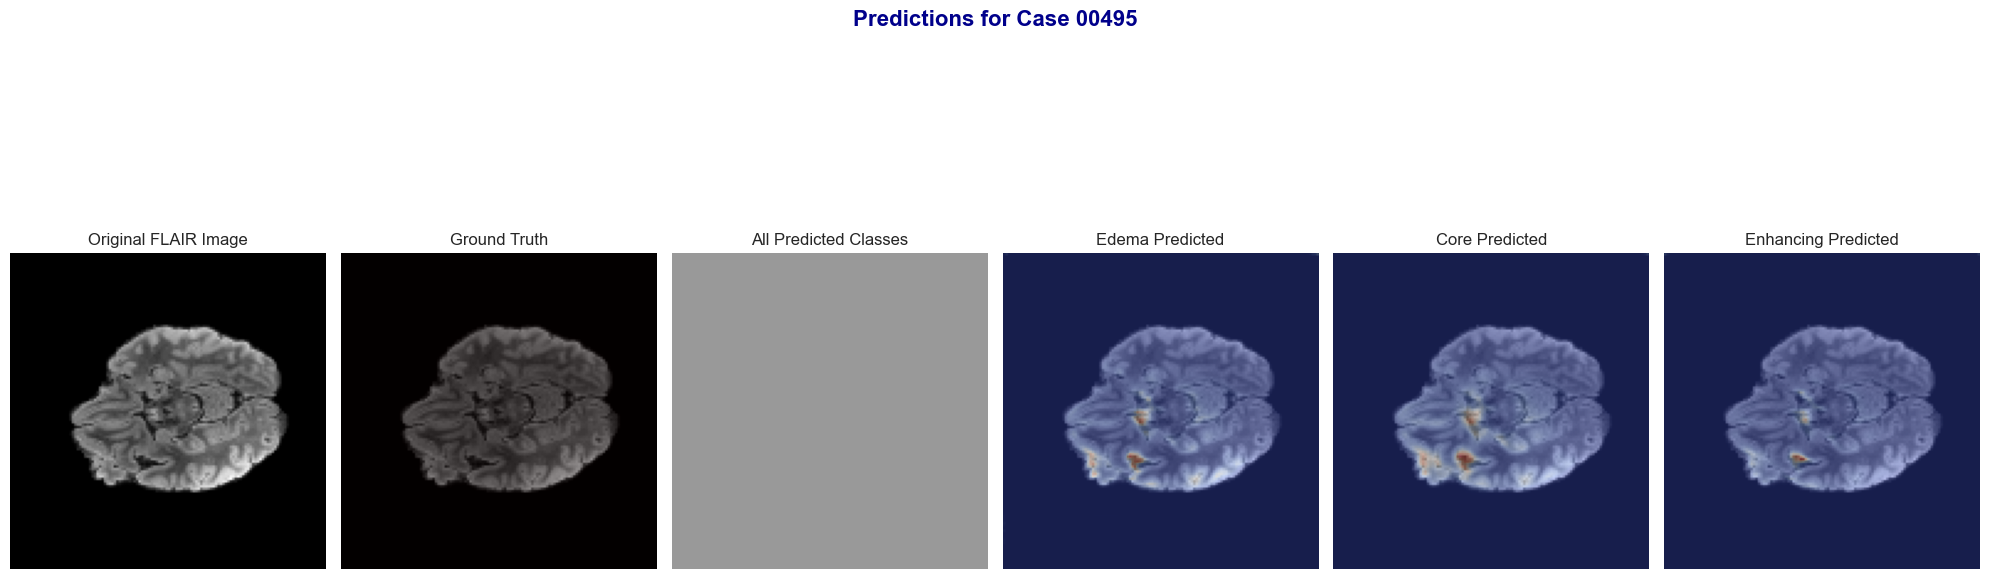

5/5 [==============================] - 5s 868ms/step


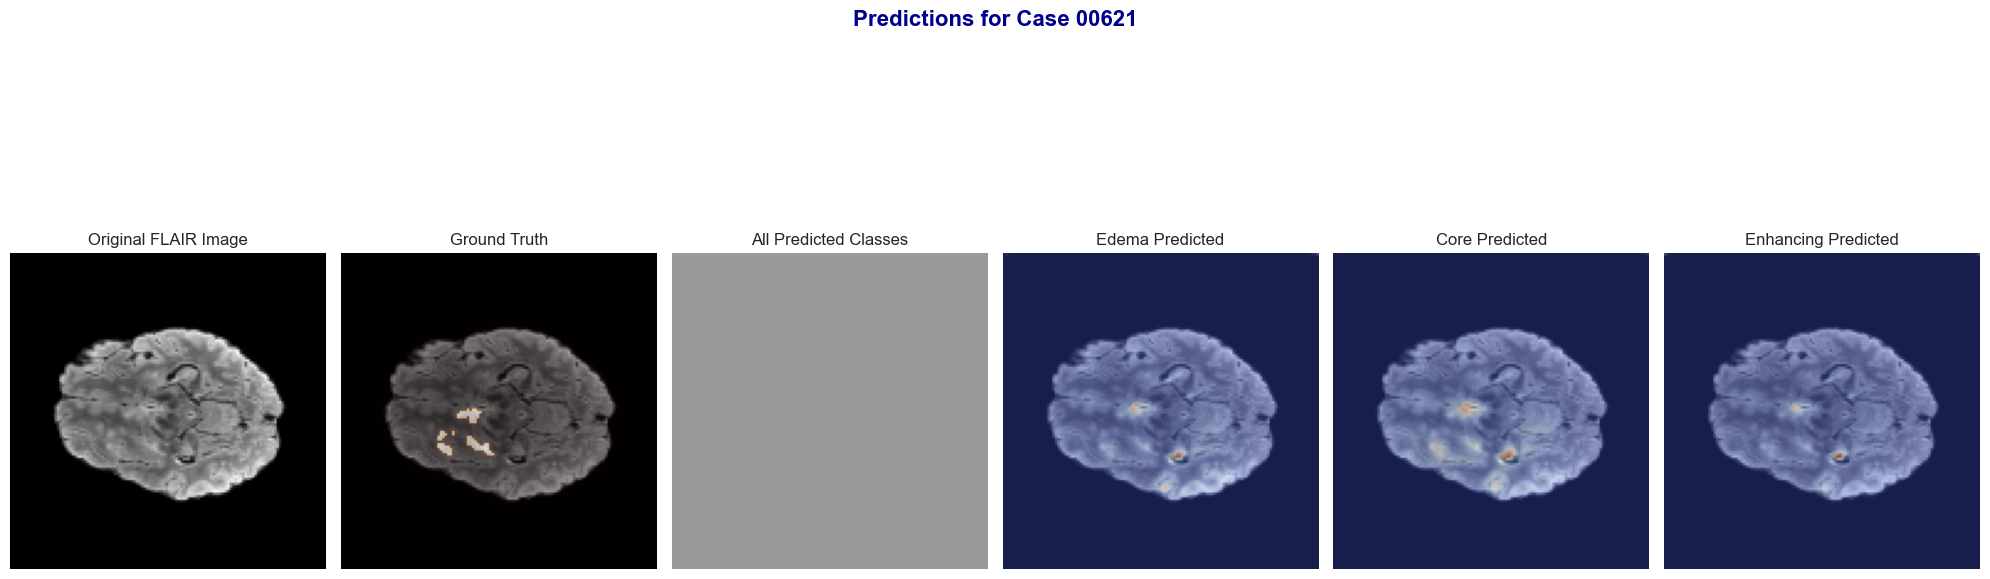

In [107]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 155  # Adjust this according to your dataset
VOLUME_START_AT = 0  # Adjust this if needed for your data
SEGMENT_CLASSES = {1: "Edema", 2: "Core", 3: "Enhancing"}  # Classes for segmentation

# Load the trained model
model = load_model('Models/Trained_4modalityvisnetCNN_Model.h5', compile=False)

# Function to preprocess and make predictions
def predict1(case_path, case):
    # Initialize an empty array for predictor with four channels (FLAIR, T1, T1CE, T2)
    predictor = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4))

    # Load FLAIR, T1, T1CE, and T2 modalities
    flair_path = os.path.join('MRI', case_path, f'{case_path}_flair.nii')
    t1_path = os.path.join('MRI', case_path, f'{case_path}_t1.nii')
    t1ce_path = os.path.join('MRI', case_path, f'{case_path}_t1ce.nii')
    t2_path = os.path.join('MRI', case_path, f'{case_path}_t2.nii')

    flair = nib.load(flair_path).get_fdata()
    t1 = nib.load(t1_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()

    # Process the slices for FLAIR, T1, T1CE, and T2
    for j in range(VOLUME_SLICES):
        predictor[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        predictor[j, :, :, 1] = cv2.resize(t1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        predictor[j, :, :, 2] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        predictor[j, :, :, 3] = cv2.resize(t2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize the input
    predictor = predictor / np.max(predictor)

    # Make predictions using the model
    predictions = model.predict(predictor, verbose=1)
    return predictions

# Function to visualize predictions in a publication-ready style
def predict(case, case_folder, start_slice=60, save_fig=True):
    case_path = case_folder

    # Load ground truth segmentation and original FLAIR image
    gt_path = os.path.join('MRI', case_path, f'{case_path}_seg.nii')
    flair_path = os.path.join('MRI', case_path, f'{case_path}_flair.nii')

    gt = nib.load(gt_path).get_fdata()
    original_image = nib.load(flair_path).get_fdata()

    # Get predictions from the model
    predictions = predict1(case_path, case)

    # Extract the predicted classes
    core = predictions[:, :, :, 1]  # Tumor core
    edema = predictions[:, :, :, 2]  # Edema
    enhancing = predictions[:, :, :, 3]  # Enhancing tumor

    # Create a subplot to visualize the results
    fig, axarr = plt.subplots(1, 6, figsize=(20, 8))
    fig.suptitle(f'Predictions for Case {case}', fontsize=16, fontweight='bold', color='darkblue')

    # Apply a consistent color scheme and style for clarity
    cmap_pred = "coolwarm"  # Colormap for predicted regions
    cmap_truth = "hot"  # Colormap for ground truth regions
    alpha_overlay = 0.4  # Transparency for overlays

    # Original Image FLAIR
    axarr[0].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original FLAIR Image')
    axarr[0].axis('off')

    # Ground Truth
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[1].imshow(curr_gt, cmap=cmap_truth, alpha=alpha_overlay)
    axarr[1].title.set_text('Ground Truth')
    axarr[1].axis('off')

    # All predicted classes
    axarr[2].imshow(predictions[start_slice, :, :, 1:4], cmap=cmap_pred, alpha=alpha_overlay)
    axarr[2].title.set_text('All Predicted Classes')
    axarr[2].axis('off')

    # Edema Prediction
    axarr[3].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[3].imshow(edema[start_slice, :, :], cmap=cmap_pred, alpha=alpha_overlay)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')
    axarr[3].axis('off')

    # Core Prediction
    axarr[4].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[4].imshow(core[start_slice, :, :], cmap=cmap_pred, alpha=alpha_overlay)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')
    axarr[4].axis('off')

    # Enhancing Prediction
    axarr[5].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[5].imshow(enhancing[start_slice, :, :], cmap=cmap_pred, alpha=alpha_overlay)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')
    axarr[5].axis('off')

    plt.tight_layout()

    # Save the figure as an image for use in research papers
    if save_fig:
        fig.savefig(f'prediction_case_{case}.png', bbox_inches='tight', dpi=300)
    
    plt.show()

# Example usage: Visualize predictions for a specific patient case in MRI/ folder
patient_folder = "BraTS2021_00495"  # Adjust this to match your actual folder structure
predict(case="00495", case_folder=patient_folder, start_slice=60)

patient_folder = "BraTS2021_00621"  # Adjust this to match your actual folder structure
predict(case="00621", case_folder=patient_folder, start_slice=60)


5/5 [==============================] - 4s 799ms/step


<Figure size 1800x5000 with 0 Axes>

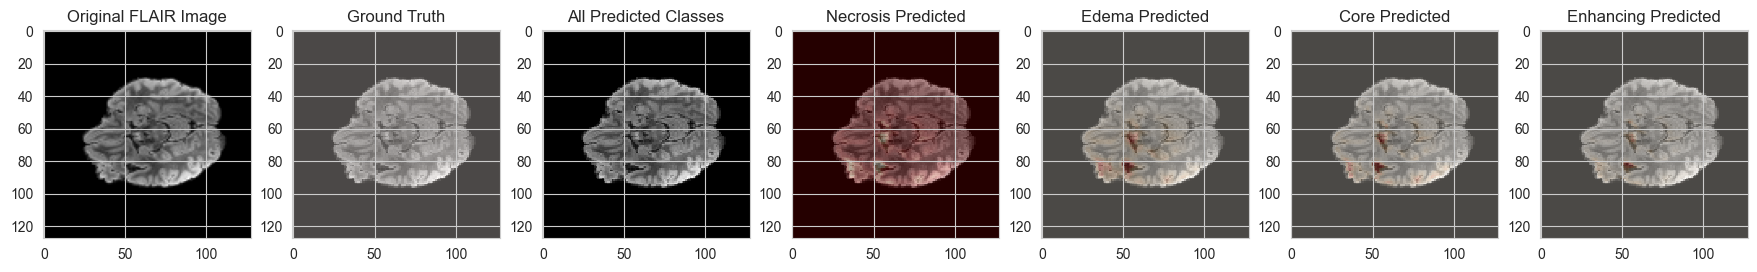

5/5 [==============================] - 4s 798ms/step


<Figure size 1800x5000 with 0 Axes>

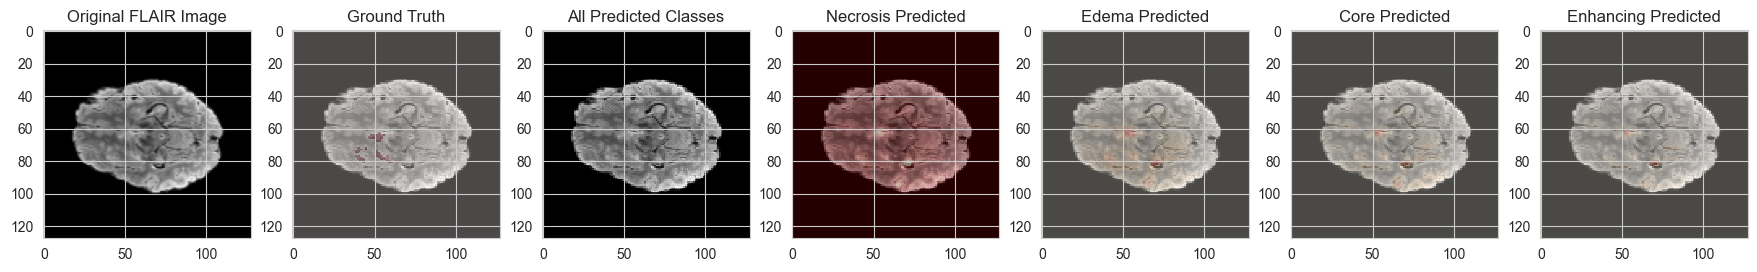

In [108]:
import os
import numpy as np
import nibabel as nib
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = 128
VOLUME_SLICES = 155  # Adjust this according to your dataset
VOLUME_START_AT = 0  # Adjust this if needed for your data
SEGMENT_CLASSES = {1: "Necrosis", 2: "Edema", 3: "Core", 4: "Enhancing"}  # Classes for segmentation

# Load the trained model
model = load_model('Models/Trained_4modalityvisnetCNN_Model.h5', compile=False)

# Function to preprocess and make predictions
def predict1(case_path, case):
    # Initialize an empty array for predictor with four channels (FLAIR, T1, T1CE, T2)
    predictor = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 4))

    # Load FLAIR, T1, T1CE, and T2 modalities
    flair_path = os.path.join('MRI', case_path, f'{case_path}_flair.nii')
    t1_path = os.path.join('MRI', case_path, f'{case_path}_t1.nii')
    t1ce_path = os.path.join('MRI', case_path, f'{case_path}_t1ce.nii')
    t2_path = os.path.join('MRI', case_path, f'{case_path}_t2.nii')

    flair = nib.load(flair_path).get_fdata()
    t1 = nib.load(t1_path).get_fdata()
    t1ce = nib.load(t1ce_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()

    # Process the slices for FLAIR, T1, T1CE, and T2
    for j in range(VOLUME_SLICES):
        predictor[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        predictor[j, :, :, 1] = cv2.resize(t1[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        predictor[j, :, :, 2] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        predictor[j, :, :, 3] = cv2.resize(t2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normalize the input
    predictor = predictor / np.max(predictor)

    # Make predictions using the model
    predictions = model.predict(predictor, verbose=1)
    return predictions

# Function to visualize predictions with four classes
def predict(case, case_folder, start_slice=60):
    case_path = case_folder

    # Load ground truth segmentation and original FLAIR image
    gt_path = os.path.join('MRI', case_path, f'{case_path}_seg.nii')
    flair_path = os.path.join('MRI', case_path, f'{case_path}_flair.nii')

    gt = nib.load(gt_path).get_fdata()
    original_image = nib.load(flair_path).get_fdata()

    # Get predictions from the model
    predictions = predict1(case_path, case)

    # Extract the predicted classes
    necrosis = predictions[:, :, :, 0]  # Necrotic tumor region
    edema = predictions[:, :, :, 1]  # Edema
    core = predictions[:, :, :, 2]  # Tumor core
    enhancing = predictions[:, :, :, 3]  # Enhancing tumor

    # Create a subplot to visualize the results
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1, 7, figsize=(22, 50))  # Adjusting for 4 classes + original and ground truth

    for i in range(7):
        axarr[i].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')

    # Original Image FLAIR
    axarr[0].imshow(cv2.resize(original_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original FLAIR Image')

    # Ground Truth
    curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground Truth')

    # All predicted classes (Necrosis, Edema, Core, Enhancing)
    axarr[2].imshow(predictions[start_slice, :, :, 0:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('All Predicted Classes')

    # Necrosis Prediction
    axarr[3].imshow(necrosis[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} Predicted')

    # Edema Prediction
    axarr[4].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} Predicted')

    # Core Prediction
    axarr[5].imshow(core[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} Predicted')

    # Enhancing Prediction
    axarr[6].imshow(enhancing[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[6].title.set_text(f'{SEGMENT_CLASSES[4]} Predicted')

    plt.show()

# Example usage: Visualize predictions for a specific patient case in MRI/ folder
patient_folder = "BraTS2021_00495"  # Adjust this to match your actual folder structure
predict(case="00495", case_folder=patient_folder, start_slice=60)

patient_folder = "BraTS2021_00621"  # Adjust this to match your actual folder structure
predict(case="00621", case_folder=patient_folder, start_slice=60)


In [112]:
from tensorflow.keras import layers, models
from collections import defaultdict
from PIL import ImageFont
import visualkeras

In [114]:
# model = load_model('Models/Trained_4modalityvisnetCNN_Model.h5', compile=False)
# font = ImageFont.truetype("arial.ttf", 12)

# # Define color mapping for the layers
# color_map = defaultdict(dict)
# color_map[layers.Conv2D]['fill'] = '#00f5d4'
# color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
# color_map[layers.Dropout]['fill'] = '#03045e'
# color_map[layers.Dense]['fill'] = '#fb5607'
# color_map[layers.Flatten]['fill'] = '#ffbe0b'

# # Generate the visualization with a legend and custom colors
# visualkeras.layered_view(model, legend=True, font=font, color_map=color_map).show()  # .show() to display or .save() to save the image

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate a toy dataset
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Get the predicted probabilities for the test set
y_scores = model.predict_proba(test_generator)[:, 1]  # Get probabilities for class 1

# y_test will serve as y_true (ground truth)
y_true = y_test


Batch ['BraTS2021\\BraTS2021_00805']
Case Path: Data/BraTS2021\BraTS2021_00805\BraTS2021_00805
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_00251']
Case Path: Data/BraTS2021\BraTS2021_00251\BraTS2021_00251
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_01185']
Case Path: Data/BraTS2021\BraTS2021_01185\BraTS2021_01185
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_01568']
Case Path: Data/BraTS2021\BraTS2021_01568\BraTS2021_01568
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_01228']
Case Path: Data/BraTS2021\BraTS2021_01228\BraTS2021_01228
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_00016']
Case Path: Data/BraTS2021\BraTS2021_00016\BraTS2021_00016
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_01073']
Case Path: Data/BraTS2021\BraTS2021_01073\BraTS2021_01073
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_01169']
Case Path: Data/BraTS2021\BraTS2021_01169\BraTS2021_01169
Processed patient: 0
Batch ['BraTS2021\\BraTS2021_00113']
Case Path: Data/BraTS2021\BraTS2021

ValueError: Found array with dim 6. LogisticRegression expected <= 2.

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



# Compute the confusion matrix
cm = np.zeros((4, 4))
for i in range(len(true_labels)):
    cm[true_labels[i], pred_labels[i]] += 1

# Plot the confusion matrix
class_names = ['NOT tumor', 'NECROTIC/CORE', 'EDEMA', 'ENHANCING']
plot_confusion_matrix(cm, classes=class_names, title='Brain Tumor Segmentation Confusion Matrix')
plt.show()
